In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_5995.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/Leaf_scald (86).jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_5914.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_2467.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_2138.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_914.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_3199.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_2738.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_143.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_1933.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_3645.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_890.jpg
/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/Leaf_scald (29).jpg
/kaggle/input/rice

In [ ]:

!pip install torch torchvision tensorflow onnx onnx-tf scikit-learn matplotlib seaborn pillow tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 5.1 MB/s eta 0:00:0000:01


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import time
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2026-02-14 21:32:36.290864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771104756.463795      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771104756.515135      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771104756.926925      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771104756.926958      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771104756.926960      55 computation_placer.cc:177] computation placer alr

Using device: cuda
GPU: Tesla T4


In [4]:
# Cell 3: Set up data paths (Update this path according to your Kaggle dataset)
DATA_PATH = '/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG'  # Update this path
WORKING_DIR = '/kaggle/working'

# Verify the path exists
if not os.path.exists(DATA_PATH):
    print(f"ERROR: Data path {DATA_PATH} does not exist!")
    print("Please update DATA_PATH to match your Kaggle dataset location")
    print("\nAvailable paths in /kaggle/input/:")
    for item in os.listdir('/kaggle/input/'):
        print(f"  - /kaggle/input/{item}")
else:
    print(f"✓ Data path found: {DATA_PATH}")

✓ Data path found: /kaggle/input/rice-disease-dataset/Rice_Leaf_AUG


DATASET EXPLORATION

Total number of classes: 6

Class names:
  0. Bacterial Leaf Blight: 636 images
  1. Brown Spot: 646 images
  2. Healthy Rice Leaf: 653 images
  3. Leaf Blast: 634 images
  4. Leaf scald: 628 images
  5. Sheath Blight: 632 images

Total images: 3829


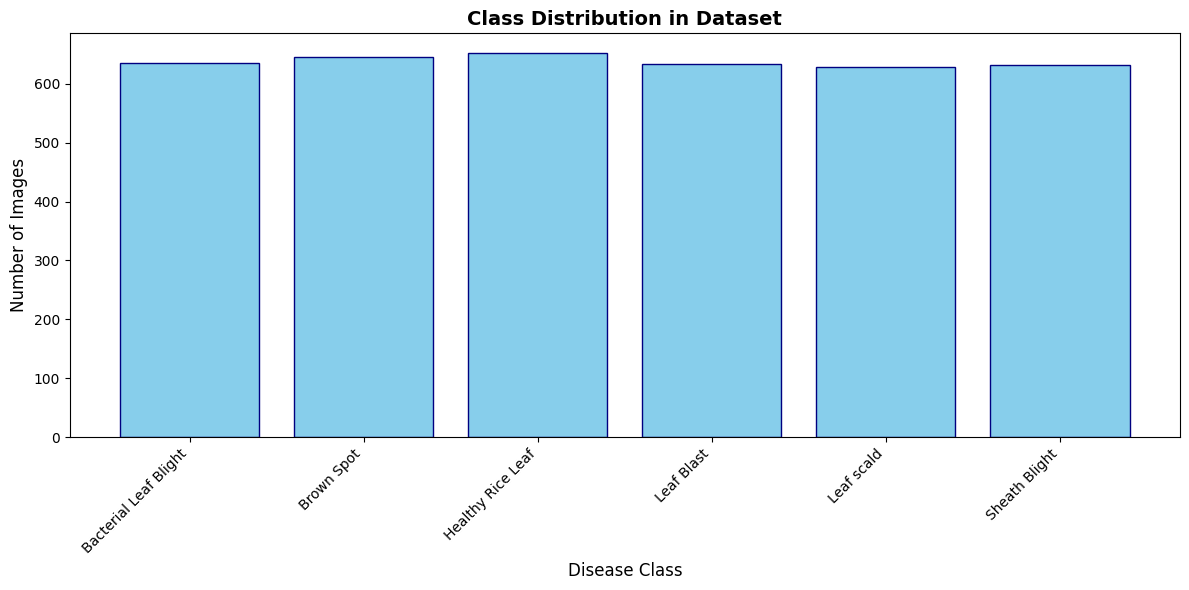

In [ ]:

def explore_dataset(data_path):
    classes = []
    class_counts = {}
    
    for item in os.listdir(data_path):
        item_path = os.path.join(data_path, item)
        if os.path.isdir(item_path):
            classes.append(item)
            image_files = [f for f in os.listdir(item_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[item] = len(image_files)
    
    classes.sort()
    
    print("="*60)
    print("DATASET EXPLORATION")
    print("="*60)
    print(f"\nTotal number of classes: {len(classes)}")
    print(f"\nClass names:")
    for i, cls in enumerate(classes):
        print(f"  {i}. {cls}: {class_counts[cls]} images")
    
    print(f"\nTotal images: {sum(class_counts.values())}")
    
    return classes, class_counts

CLASSES, CLASS_COUNTS = explore_dataset(DATA_PATH)
NUM_CLASSES = len(CLASSES)


plt.figure(figsize=(12, 6))
plt.bar(CLASSES, [CLASS_COUNTS[c] for c in CLASSES], color='skyblue', edgecolor='navy')
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:

def create_dataframe(data_path, classes):
    
    data = []
    
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                data.append({
                    'path': img_path,
                    'class_name': class_name,
                    'class_idx': classes.index(class_name)
                })
    
    df = pd.DataFrame(data)
    return df


df = create_dataframe(DATA_PATH, CLASSES)
print(f"Total samples: {len(df)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nClass distribution:")
print(df['class_name'].value_counts())

Total samples: 3829

First few rows:
                                                path             class_name  \
0  /kaggle/input/rice-disease-dataset/Rice_Leaf_A...  Bacterial Leaf Blight   
1  /kaggle/input/rice-disease-dataset/Rice_Leaf_A...  Bacterial Leaf Blight   
2  /kaggle/input/rice-disease-dataset/Rice_Leaf_A...  Bacterial Leaf Blight   
3  /kaggle/input/rice-disease-dataset/Rice_Leaf_A...  Bacterial Leaf Blight   
4  /kaggle/input/rice-disease-dataset/Rice_Leaf_A...  Bacterial Leaf Blight   

   class_idx  
0          0  
1          0  
2          0  
3          0  
4          0  

Class distribution:
class_name
Healthy Rice Leaf        653
Brown Spot               646
Bacterial Leaf Blight    636
Leaf Blast               634
Sheath Blight            632
Leaf scald               628
Name: count, dtype: int64


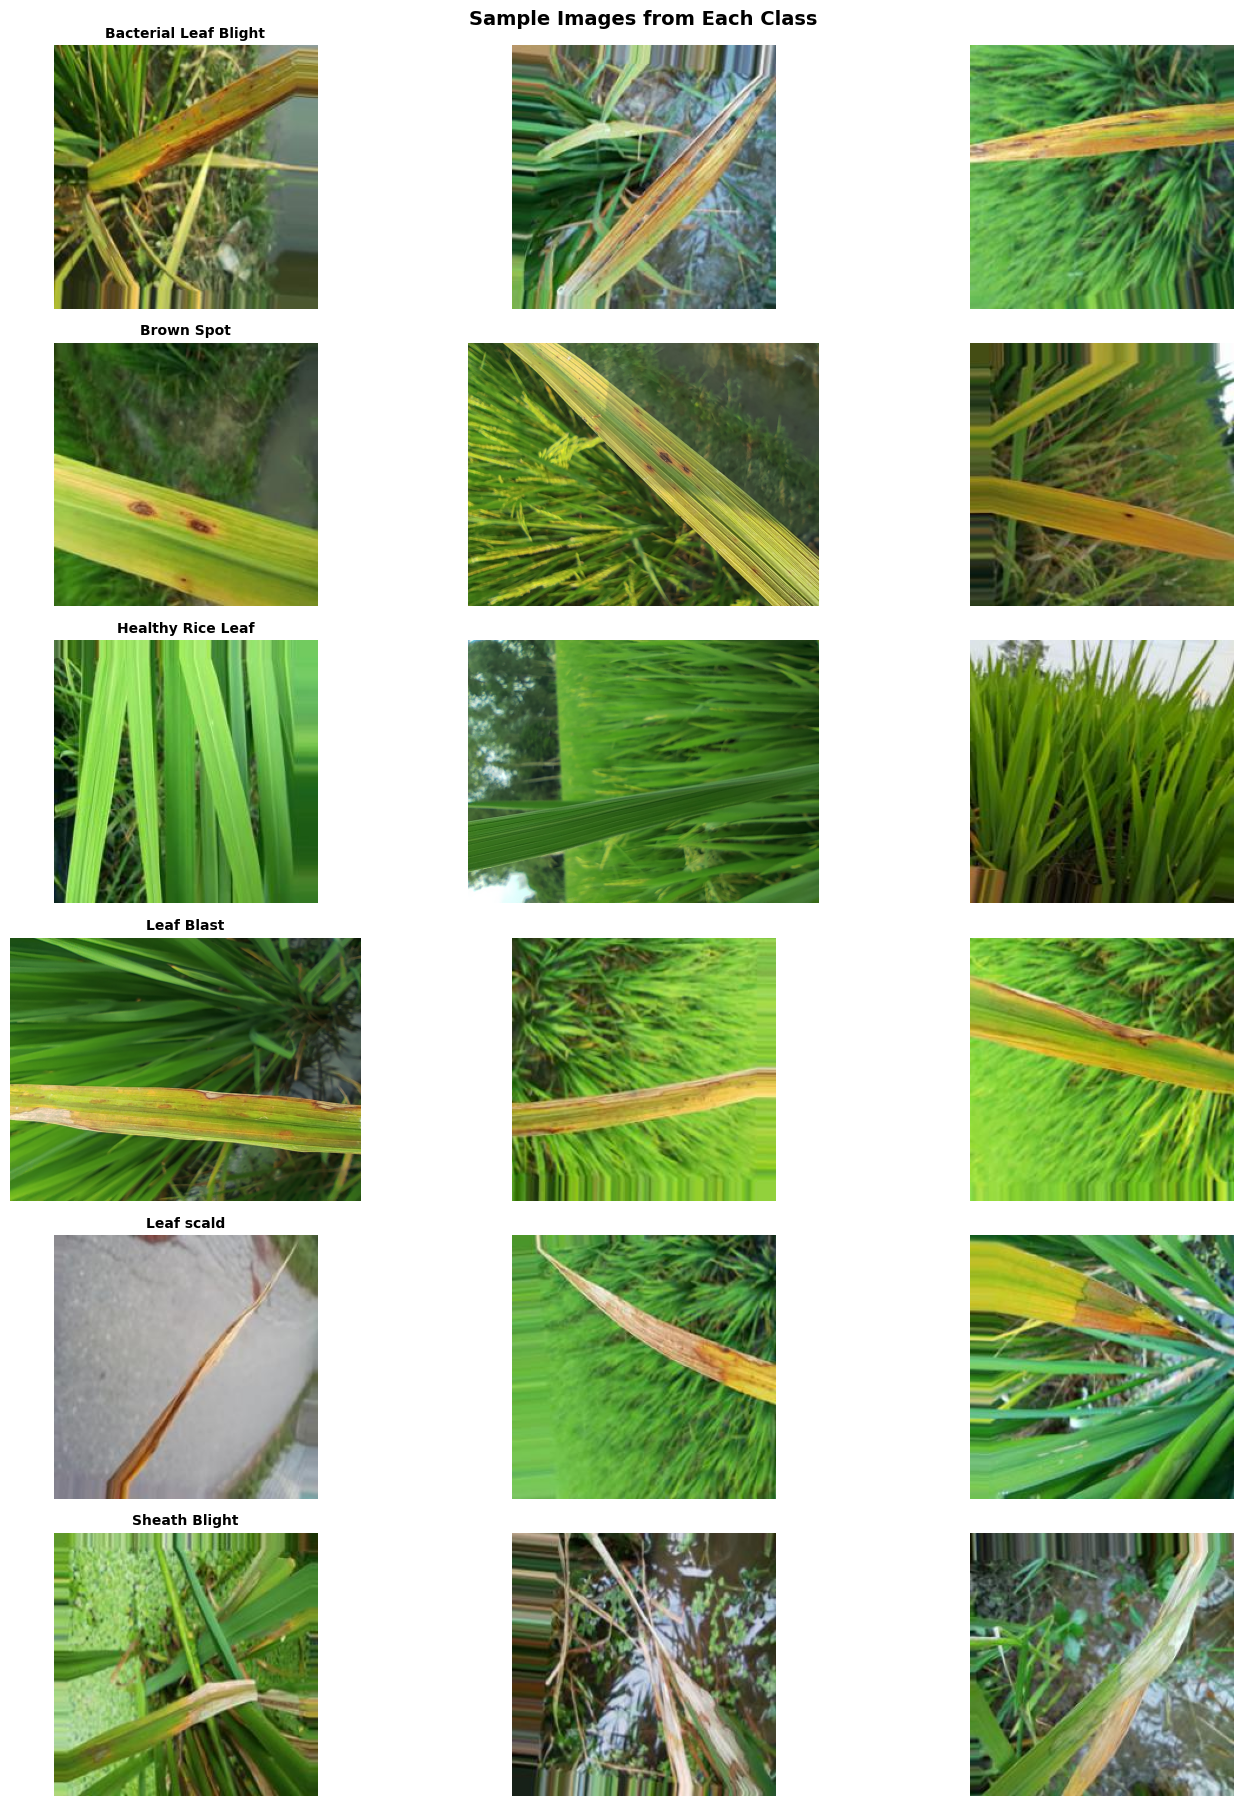

In [ ]:

def visualize_samples(df, classes, samples_per_class=3):
 
    fig, axes = plt.subplots(len(classes), samples_per_class, 
                             figsize=(15, 3*len(classes)))
    
    for i, class_name in enumerate(classes):
        class_df = df[df['class_name'] == class_name]
        samples = class_df.sample(min(samples_per_class, len(class_df)))
        
        for j, (_, row) in enumerate(samples.iterrows()):
            img = Image.open(row['path'])
            
            if len(classes) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f"{class_name}", fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold', y=1.001)
    plt.show()

visualize_samples(df, CLASSES, samples_per_class=3)

In [ ]:

from sklearn.model_selection import train_test_split

def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1.0"
    
    # First split: train and temp (val + test)
    train_df, temp_df = train_test_split(
        df, 
        test_size=(1 - train_size),
        stratify=df['class_idx'],
        random_state=random_state
    )
    
    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1 - val_ratio),
        stratify=temp_df['class_idx'],
        random_state=random_state
    )
    
    return train_df, val_df, test_df


train_df, val_df, test_df = split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15)

print("="*60)
print("DATA SPLIT SUMMARY")
print("="*60)
print(f"Training samples:   {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test samples:       {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total samples:      {len(df)}")

# Verify stratification
print("\n" + "="*60)
print("CLASS DISTRIBUTION VERIFICATION")
print("="*60)
for class_name in CLASSES:
    train_count = len(train_df[train_df['class_name'] == class_name])
    val_count = len(val_df[val_df['class_name'] == class_name])
    test_count = len(test_df[test_df['class_name'] == class_name])
    total_count = train_count + val_count + test_count
    
    print(f"\n{class_name}:")
    print(f"  Train: {train_count} ({train_count/total_count*100:.1f}%)")
    print(f"  Val:   {val_count} ({val_count/total_count*100:.1f}%)")
    print(f"  Test:  {test_count} ({test_count/total_count*100:.1f}%)")

DATA SPLIT SUMMARY
Training samples:   2680 (70.0%)
Validation samples: 574 (15.0%)
Test samples:       575 (15.0%)
Total samples:      3829

CLASS DISTRIBUTION VERIFICATION

Bacterial Leaf Blight:
  Train: 445 (70.0%)
  Val:   95 (14.9%)
  Test:  96 (15.1%)

Brown Spot:
  Train: 452 (70.0%)
  Val:   97 (15.0%)
  Test:  97 (15.0%)

Healthy Rice Leaf:
  Train: 457 (70.0%)
  Val:   98 (15.0%)
  Test:  98 (15.0%)

Leaf Blast:
  Train: 444 (70.0%)
  Val:   95 (15.0%)
  Test:  95 (15.0%)

Leaf scald:
  Train: 440 (70.1%)
  Val:   94 (15.0%)
  Test:  94 (15.0%)

Sheath Blight:
  Train: 442 (69.9%)
  Val:   95 (15.0%)
  Test:  95 (15.0%)


In [ ]:

class RiceLeafDataset(Dataset):
  
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'path']
        label = self.dataframe.loc[idx, 'class_idx']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ RiceLeafDataset class defined")

✓ RiceLeafDataset class defined


In [ ]:

IMAGE_SIZE = 224  
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Transforms defined")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Training augmentations: RandomCrop, HorizontalFlip, VerticalFlip, Rotation, ColorJitter, Affine")

✓ Transforms defined
  Image size: 224x224
  Training augmentations: RandomCrop, HorizontalFlip, VerticalFlip, Rotation, ColorJitter, Affine


In [ ]:

BATCH_SIZE = 32
NUM_WORKERS = 2


train_dataset = RiceLeafDataset(train_df, transform=train_transform)
val_dataset = RiceLeafDataset(val_df, transform=val_test_transform)
test_dataset = RiceLeafDataset(test_df, transform=val_test_transform)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print("="*60)
print("DATALOADER SUMMARY")
print("="*60)
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches:   {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches:       {len(test_loader)}")

# Test loading a batch
images, labels = next(iter(train_loader))
print(f"\nSample batch shape: {images.shape}")
print(f"Sample labels shape: {labels.shape}")
print("✓ Dataloaders created successfully")

DATALOADER SUMMARY
Batch size: 32
Training batches:   84
Validation batches: 18
Test batches:       18

Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels shape: torch.Size([32])
✓ Dataloaders created successfully


In [ ]:
# Define the baseline model (MobileNetV2)
class BaselineModel(nn.Module):
    
    def __init__(self, num_classes, pretrained=True):
        super(BaselineModel, self).__init__()
        
  
        self.backbone = models.mobilenet_v2(pretrained=pretrained)
        
      
        in_features = self.backbone.classifier[1].in_features
        
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


baseline_model = BaselineModel(num_classes=NUM_CLASSES, pretrained=True).to(device)

total_params = sum(p.numel() for p in baseline_model.parameters())
trainable_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)

print("="*60)
print("BASELINE MODEL SUMMARY")
print("="*60)
print(f"Architecture: MobileNetV2")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size (estimated): {total_params * 4 / (1024**2):.2f} MB")
print("✓ Baseline model created successfully")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 126MB/s]

BASELINE MODEL SUMMARY
Architecture: MobileNetV2
Number of classes: 6
Total parameters: 2,231,558
Trainable parameters: 2,231,558
Model size (estimated): 8.51 MB
✓ Baseline model created successfully


In [ ]:
# Define training configuration and helper functions
# Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 25
PATIENCE = 5  # For early stopping

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Optimizer: Adam")
print(f"Loss function: CrossEntropyLoss")
print(f"LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"Early stopping patience: {PATIENCE}")

TRAINING CONFIGURATION
Learning rate: 0.001
Number of epochs: 25
Optimizer: Adam
Loss function: CrossEntropyLoss
LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
Early stopping patience: 5


In [ ]:
# Define training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✓ Training functions defined")

✓ Training functions defined


In [ ]:
# Train the baseline model
print("="*60)
print("STARTING BASELINE MODEL TRAINING")
print("="*60)

# Initialize tracking variables
best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(baseline_model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(baseline_model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = baseline_model.state_dict().copy()
        epochs_no_improve = 0
        print(f"  ✓ New best validation accuracy: {best_val_acc:.2f}%")
        
        # Save best model
        torch.save(best_model_state, os.path.join(WORKING_DIR, 'baseline_best.pth'))
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")
    
    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Load best model
baseline_model.load_state_dict(best_model_state)
print(f"\n{'='*60}")
print(f"TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

STARTING BASELINE MODEL TRAINING

Epoch 1/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s, loss=0.5838, acc=71.60%]



Epoch 1 Summary:
  Train Loss: 1.0584 | Train Acc: 59.78%
  Val Loss:   0.8142 | Val Acc:   71.60%
  ✓ New best validation accuracy: 71.60%

Epoch 2/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.03it/s, loss=0.4279, acc=77.53%]



Epoch 2 Summary:
  Train Loss: 0.7649 | Train Acc: 72.57%
  Val Loss:   0.5946 | Val Acc:   77.53%
  ✓ New best validation accuracy: 77.53%

Epoch 3/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.15it/s, loss=0.5455, acc=77.00%]



Epoch 3 Summary:
  Train Loss: 0.6209 | Train Acc: 78.36%
  Val Loss:   0.6436 | Val Acc:   77.00%
  No improvement for 1 epoch(s)

Epoch 4/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.09it/s, loss=0.3299, acc=86.59%]



Epoch 4 Summary:
  Train Loss: 0.6243 | Train Acc: 77.65%
  Val Loss:   0.3951 | Val Acc:   86.59%
  ✓ New best validation accuracy: 86.59%

Epoch 5/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.12it/s, loss=0.3430, acc=79.79%]



Epoch 5 Summary:
  Train Loss: 0.4855 | Train Acc: 82.65%
  Val Loss:   0.6145 | Val Acc:   79.79%
  No improvement for 1 epoch(s)

Epoch 6/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.01it/s, loss=0.1343, acc=89.20%]



Epoch 6 Summary:
  Train Loss: 0.4373 | Train Acc: 84.33%
  Val Loss:   0.3209 | Val Acc:   89.20%
  ✓ New best validation accuracy: 89.20%

Epoch 7/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.18it/s, loss=0.2472, acc=81.88%]



Epoch 7 Summary:
  Train Loss: 0.4253 | Train Acc: 84.51%
  Val Loss:   0.5777 | Val Acc:   81.88%
  No improvement for 1 epoch(s)

Epoch 8/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.09it/s, loss=0.1819, acc=83.45%]



Epoch 8 Summary:
  Train Loss: 0.4061 | Train Acc: 86.27%
  Val Loss:   0.4435 | Val Acc:   83.45%
  No improvement for 2 epoch(s)

Epoch 9/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.04it/s, loss=0.2431, acc=87.63%]



Epoch 9 Summary:
  Train Loss: 0.4457 | Train Acc: 84.93%
  Val Loss:   0.3523 | Val Acc:   87.63%
  No improvement for 3 epoch(s)

Epoch 10/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.15it/s, loss=0.1004, acc=89.55%]



Epoch 10 Summary:
  Train Loss: 0.3999 | Train Acc: 86.49%
  Val Loss:   0.3219 | Val Acc:   89.55%
  ✓ New best validation accuracy: 89.55%

Epoch 11/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  4.93it/s, loss=0.0760, acc=94.77%]



Epoch 11 Summary:
  Train Loss: 0.2371 | Train Acc: 92.76%
  Val Loss:   0.1720 | Val Acc:   94.77%
  ✓ New best validation accuracy: 94.77%

Epoch 12/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.00it/s, loss=0.0561, acc=94.25%]



Epoch 12 Summary:
  Train Loss: 0.2070 | Train Acc: 92.99%
  Val Loss:   0.1747 | Val Acc:   94.25%
  No improvement for 1 epoch(s)

Epoch 13/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.00it/s, loss=0.1084, acc=94.60%]



Epoch 13 Summary:
  Train Loss: 0.1850 | Train Acc: 93.92%
  Val Loss:   0.1774 | Val Acc:   94.60%
  No improvement for 2 epoch(s)

Epoch 14/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.03it/s, loss=0.0567, acc=94.43%]



Epoch 14 Summary:
  Train Loss: 0.1871 | Train Acc: 93.73%
  Val Loss:   0.1675 | Val Acc:   94.43%
  No improvement for 3 epoch(s)

Epoch 15/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.24it/s, loss=0.0966, acc=94.77%]



Epoch 15 Summary:
  Train Loss: 0.1675 | Train Acc: 94.07%
  Val Loss:   0.1939 | Val Acc:   94.77%
  No improvement for 4 epoch(s)

Epoch 16/25
------------------------------------------------------------


Validation: 100%|██████████| 18/18 [00:03<00:00,  5.13it/s, loss=0.0921, acc=94.77%]


Epoch 16 Summary:
  Train Loss: 0.1672 | Train Acc: 94.44%
  Val Loss:   0.1731 | Val Acc:   94.77%
  No improvement for 5 epoch(s)

Early stopping triggered after 16 epochs

TRAINING COMPLETE
Best validation accuracy: 94.77%


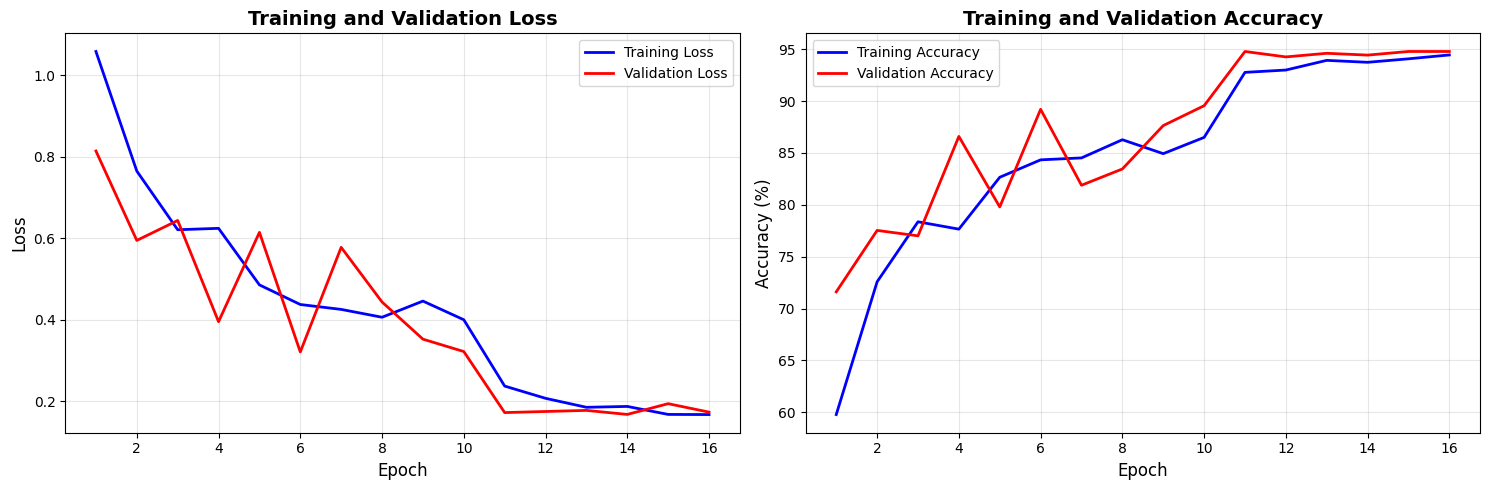

In [ ]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    # Plot loss
    ax1.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate on test set
def evaluate_model(model, dataloader, device, classes):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Classification report
    print("="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, cm, all_preds, all_labels, all_probs

# Evaluate baseline model
baseline_test_acc, baseline_cm, _, _, _ = evaluate_model(
    baseline_model, test_loader, device, CLASSES
)

print(f"\n{'='*60}")
print(f"BASELINE MODEL TEST ACCURACY: {baseline_test_acc*100:.2f}%")
print(f"{'='*60}")

Evaluating: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

CLASSIFICATION REPORT
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.98      0.91      0.94        96
           Brown Spot       0.98      0.96      0.97        97
    Healthy Rice Leaf       0.99      1.00      0.99        98
           Leaf Blast       0.90      0.97      0.93        95
           Leaf scald       0.90      0.96      0.93        94
        Sheath Blight       0.99      0.94      0.96        95

             accuracy                           0.95       575
            macro avg       0.96      0.95      0.95       575
         weighted avg       0.96      0.95      0.95       575


BASELINE MODEL TEST ACCURACY: 95.48%


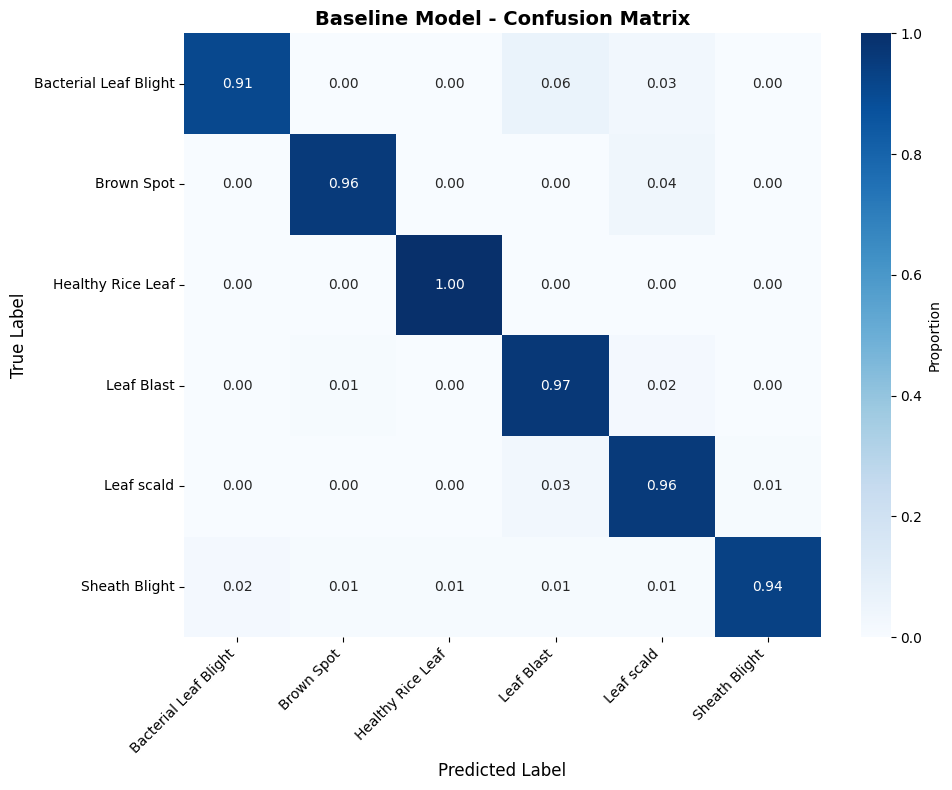

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Proportion'})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(baseline_cm, CLASSES, 'Baseline Model - Confusion Matrix')

In [ ]:
# Measure baseline inference time
def measure_inference_time(model, dataloader, device, num_samples=100):
    model.eval()
    
    times = []
    count = 0
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            
            for i in range(images.size(0)):
                if count >= num_samples:
                    break
                
                single_image = images[i:i+1]
                
                # Warm up
                if count == 0:
                    for _ in range(10):
                        _ = model(single_image)
                
                # Measure time
                start_time = time.time()
                _ = model(single_image)
                if device.type == 'cuda':
                    torch.cuda.synchronize()
                end_time = time.time()
                
                times.append((end_time - start_time) * 1000)  # Convert to ms
                count += 1
            
            if count >= num_samples:
                break
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    return avg_time, std_time

baseline_avg_time, baseline_std_time = measure_inference_time(baseline_model, test_loader, device)

print("="*60)
print("BASELINE MODEL INFERENCE TIME")
print("="*60)
print(f"Average: {baseline_avg_time:.2f} ms")
print(f"Std Dev: {baseline_std_time:.2f} ms")
print(f"Device: {device}")

BASELINE MODEL INFERENCE TIME
Average: 6.97 ms
Std Dev: 1.62 ms
Device: cuda


In [ ]:
# Calculate baseline model size
def get_model_size(model, filepath):
    torch.save(model.state_dict(), filepath)
    size_mb = os.path.getsize(filepath) / (1024 ** 2)
    return size_mb

baseline_size = get_model_size(baseline_model, os.path.join(WORKING_DIR, 'baseline_model.pth'))

print("="*60)
print("BASELINE MODEL SIZE")
print("="*60)
print(f"Model size: {baseline_size:.2f} MB")

BASELINE MODEL SIZE
Model size: 8.75 MB


In [ ]:
# Apply quantization to create edge model
print("="*60)
print("CREATING OPTIMIZED EDGE MODEL")
print("="*60)

# Create a copy of the baseline model for quantization
edge_model = BaselineModel(num_classes=NUM_CLASSES, pretrained=False).to('cpu')
edge_model.load_state_dict(baseline_model.state_dict())
edge_model.eval()

# Prepare model for quantization
edge_model_quantized = torch.quantization.quantize_dynamic(
    edge_model,
    {nn.Linear, nn.Conv2d},
    dtype=torch.qint8
)

print("✓ Dynamic quantization applied (int8)")

# Save quantized model
quantized_path = os.path.join(WORKING_DIR, 'edge_model_quantized.pth')
torch.save(edge_model_quantized.state_dict(), quantized_path)

edge_size = os.path.getsize(quantized_path) / (1024 ** 2)
print(f"✓ Edge model size: {edge_size:.2f} MB")
print(f"✓ Size reduction: {((baseline_size - edge_size) / baseline_size * 100):.1f}%")

CREATING OPTIMIZED EDGE MODEL
✓ Dynamic quantization applied (int8)
✓ Edge model size: 8.73 MB
✓ Size reduction: 0.3%


In [ ]:
# Evaluate edge model accuracy
print("\n" + "="*60)
print("EVALUATING EDGE MODEL")
print("="*60)

# Move edge model to CPU for inference (simulating edge device)
edge_model_quantized = edge_model_quantized.to('cpu')

# Create CPU dataloader for edge evaluation
test_loader_cpu = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0  # Use 0 for CPU
)

edge_test_acc, edge_cm, _, _, _ = evaluate_model(
    edge_model_quantized, test_loader_cpu, 'cpu', CLASSES
)

print(f"\n{'='*60}")
print(f"EDGE MODEL TEST ACCURACY: {edge_test_acc*100:.2f}%")
print(f"Accuracy drop: {(baseline_test_acc - edge_test_acc)*100:.2f}%")
print(f"{'='*60}")


EVALUATING EDGE MODEL


Evaluating: 100%|██████████| 18/18 [00:41<00:00,  2.28s/it]

CLASSIFICATION REPORT
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.98      0.91      0.94        96
           Brown Spot       0.98      0.96      0.97        97
    Healthy Rice Leaf       0.99      1.00      0.99        98
           Leaf Blast       0.90      0.97      0.93        95
           Leaf scald       0.90      0.96      0.93        94
        Sheath Blight       0.99      0.94      0.96        95

             accuracy                           0.95       575
            macro avg       0.96      0.95      0.95       575
         weighted avg       0.96      0.95      0.95       575


EDGE MODEL TEST ACCURACY: 95.48%
Accuracy drop: 0.00%


In [ ]:
# Single Image Inference Function
def predict_single_image(model, image_path, classes, device='cpu', model_type='pytorch'):
    """
    Predict disease class for a single rice leaf image
    
    Args:
        model: Trained model (PyTorch or TFLite interpreter)
        image_path: Path to the image file
        classes: List of class names
        device: Device to run inference on
        model_type: 'pytorch' or 'tflite'
    
    Returns:
        predicted_class: Name of predicted disease
        confidence: Confidence score (0-1)
        all_probabilities: Dictionary of all class probabilities
    """
    
    if model_type == 'pytorch':
        # PyTorch inference
        model.eval()
        model = model.to(device)
        
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = val_test_transform(image).unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
        
        predicted_class = classes[predicted_idx.item()]
        confidence_score = confidence.item()
        
        # Get all probabilities
        all_probs = probabilities.cpu().numpy()[0]
        prob_dict = {classes[i]: float(all_probs[i]) for i in range(len(classes))}
        
    elif model_type == 'tflite':
        # TFLite inference
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = val_test_transform(image).unsqueeze(0).numpy()
        
        # Get prediction
        input_details = model.get_input_details()
        output_details = model.get_output_details()
        
        model.set_tensor(input_details[0]['index'], image_tensor)
        model.invoke()
        outputs = model.get_tensor(output_details[0]['index'])
        
        # Apply softmax
        probabilities = np.exp(outputs) / np.sum(np.exp(outputs), axis=1, keepdims=True)
        predicted_idx = np.argmax(probabilities[0])
        confidence_score = probabilities[0][predicted_idx]
        predicted_class = classes[predicted_idx]
        
        # Get all probabilities
        prob_dict = {classes[i]: float(probabilities[0][i]) for i in range(len(classes))}
    
    return predicted_class, confidence_score, prob_dict


def visualize_prediction(image_path, predicted_class, confidence, all_probabilities, true_label=None):
    """
    Visualize the prediction with image and probability bar chart
    
    Args:
        image_path: Path to the image
        predicted_class: Predicted class name
        confidence: Confidence score
        all_probabilities: Dictionary of all class probabilities
        true_label: Optional true label for comparison
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display image
    image = Image.open(image_path)
    ax1.imshow(image)
    ax1.axis('off')
    
    # Title with prediction
    title = f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}"
    if true_label:
        title += f"\nTrue Label: {true_label}"
        if predicted_class == true_label:
            title += " ✓"
        else:
            title += " ✗"
    
    ax1.set_title(title, fontsize=14, fontweight='bold')
    
    # Plot probability bar chart
    classes_list = list(all_probabilities.keys())
    probs_list = list(all_probabilities.values())
    
    # Sort by probability
    sorted_indices = np.argsort(probs_list)[::-1]
    sorted_classes = [classes_list[i] for i in sorted_indices]
    sorted_probs = [probs_list[i] for i in sorted_indices]
    
    # Color bars - highlight predicted class
    colors = ['green' if cls == predicted_class else 'skyblue' for cls in sorted_classes]
    
    bars = ax2.barh(sorted_classes, sorted_probs, color=colors, edgecolor='navy')
    ax2.set_xlabel('Probability', fontsize=12)
    ax2.set_title('Class Probabilities', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 1)
    
    # Add percentage labels on bars
    for i, (bar, prob) in enumerate(zip(bars, sorted_probs)):
        ax2.text(prob + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{prob:.1%}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("✓ Inference functions defined")

✓ Inference functions defined


SINGLE IMAGE INFERENCE TEST

Test Image: /kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Sheath Blight/IMG_20231006_163217.jpg
True Label: Leaf Blast

Using Baseline PyTorch Model:
  Predicted: Sheath Blight
  Confidence: 99.23%
  Correct: False


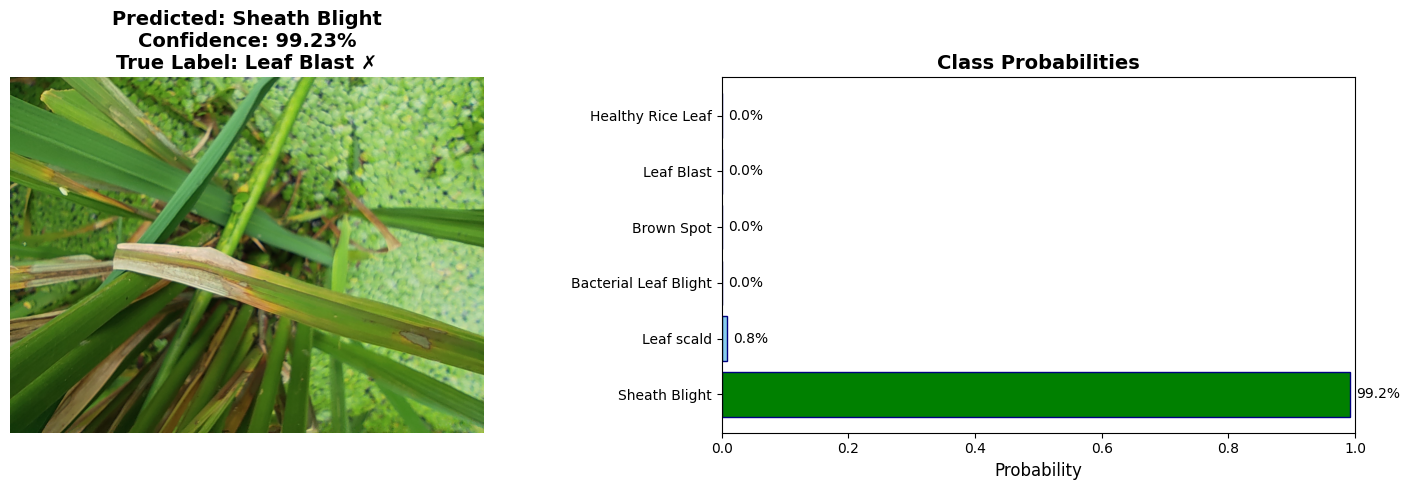

In [ ]:
# Test with a single image from test set
print("="*60)
print("SINGLE IMAGE INFERENCE TEST")
print("="*60)

# Select a random test image
test_sample = test_df.sample(1).iloc[0]
test_image_path = "/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Sheath Blight/IMG_20231006_163217.jpg"
true_class_idx = test_sample['class_idx']
true_class_name = test_sample['class_name']

print(f"\nTest Image: {test_image_path}")
print(f"True Label: {true_class_name}\n")

# Option 1: Predict using baseline PyTorch model
print("Using Baseline PyTorch Model:")
predicted_class, confidence, all_probs = predict_single_image(
    baseline_model, 
    test_image_path, 
    CLASSES, 
    device=device,
    model_type='pytorch'
)

print(f"  Predicted: {predicted_class}")
print(f"  Confidence: {confidence:.2%}")
print(f"  Correct: {predicted_class == true_class_name}")

# Visualize
visualize_prediction(test_image_path, predicted_class, confidence, all_probs, true_class_name)

In [ ]:
# Create a custom wrapper class for easy inference
import pickle

class RiceLeafDiseaseDetector:
    """
    Complete Rice Leaf Disease Detection Model
    Usage: 
        model = RiceLeafDiseaseDetector.load('rice_disease_model.pkl')
        result = model.predict('path/to/image.jpg')
    """
    
    def __init__(self, model, classes, image_size=224, device='cpu'):
        self.model = model
        self.classes = classes
        self.image_size = image_size
        self.device = device
        self.model.to(device)
        self.model.eval()
        
        # Define transform
        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def predict(self, image_path, return_probs=False):
        """
        Predict disease class for a rice leaf image
        
        Args:
            image_path: Path to image file (str) or PIL Image object
            return_probs: If True, returns all class probabilities
        
        Returns:
            If return_probs=False: Dictionary with predicted_class and confidence
            If return_probs=True: Dictionary with predicted_class, confidence, and all_probabilities
        """
        # Load image
        if isinstance(image_path, str):
            image = Image.open(image_path).convert('RGB')
        else:
            image = image_path.convert('RGB')
        
        # Preprocess
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        # Predict
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
        
        predicted_class = self.classes[predicted_idx.item()]
        confidence_score = float(confidence.item())
        
        result = {
            'predicted_class': predicted_class,
            'confidence': confidence_score
        }
        
        if return_probs:
            all_probs = probabilities.cpu().numpy()[0]
            prob_dict = {self.classes[i]: float(all_probs[i]) for i in range(len(self.classes))}
            result['all_probabilities'] = prob_dict
        
        return result
    
    def predict_batch(self, image_paths, return_probs=False):
        """
        Predict on multiple images
        
        Args:
            image_paths: List of image paths
            return_probs: If True, returns all class probabilities
        
        Returns:
            List of prediction dictionaries
        """
        results = []
        for img_path in image_paths:
            result = self.predict(img_path, return_probs=return_probs)
            result['image_path'] = img_path
            results.append(result)
        return results
    
    def save(self, filepath):
        """Save the complete model"""
        save_dict = {
            'model_state_dict': self.model.state_dict(),
            'classes': self.classes,
            'image_size': self.image_size,
            'model_architecture': 'MobileNetV2'
        }
        torch.save(save_dict, filepath)
        print(f"✓ Model saved to {filepath}")
    
    @classmethod
    def load(cls, filepath, device='cpu'):
        """Load a saved model"""
        checkpoint = torch.load(filepath, map_location=device)
        
        # Recreate model architecture
        num_classes = len(checkpoint['classes'])
        model = BaselineModel(num_classes=num_classes, pretrained=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Create detector instance
        detector = cls(
            model=model,
            classes=checkpoint['classes'],
            image_size=checkpoint['image_size'],
            device=device
        )
        
        print(f"✓ Model loaded from {filepath}")
        print(f"  Classes: {len(detector.classes)}")
        print(f"  Device: {device}")
        
        return detector
    
    def get_classes(self):
        """Get list of disease classes"""
        return self.classes
    
    def __repr__(self):
        return f"RiceLeafDiseaseDetector(classes={len(self.classes)}, device={self.device})"

print("✓ RiceLeafDiseaseDetector class created")

✓ RiceLeafDiseaseDetector class created


In [ ]:
# Create and save the complete model
print("="*60)
print("CREATING PRODUCTION-READY MODEL")
print("="*60)

# Create the detector with the trained model
detector = RiceLeafDiseaseDetector(
    model=baseline_model,
    classes=CLASSES,
    image_size=IMAGE_SIZE,
    device=device
)

print(f"\n✓ Detector created: {detector}")

# Save the complete model
model_save_path = os.path.join(WORKING_DIR, 'rice_disease_model.pth')
detector.save(model_save_path)

# Get file size
model_size_mb = os.path.getsize(model_save_path) / (1024 ** 2)
print(f"✓ Model size: {model_size_mb:.2f} MB")

CREATING PRODUCTION-READY MODEL

✓ Detector created: RiceLeafDiseaseDetector(classes=6, device=cuda)
✓ Model saved to /kaggle/working/rice_disease_model.pth
✓ Model size: 8.75 MB


TESTING SAVED MODEL
✓ Model loaded from /kaggle/working/rice_disease_model.pth
  Classes: 6
  Device: cpu

Test Image: /kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Brown Spot/Brown_spot (167).jpg
True Label: Brown Spot

Simple Prediction:
  Disease: Brown Spot
  Confidence: 99.87%
  Correct: ✓

Prediction with All Probabilities:
  Disease: Brown Spot
  Confidence: 99.87%
  All Probabilities:
    Brown Spot: 99.87%
    Leaf scald: 0.10%
    Leaf Blast: 0.03%
    Bacterial Leaf Blight: 0.00%
    Sheath Blight: 0.00%
    Healthy Rice Leaf: 0.00%


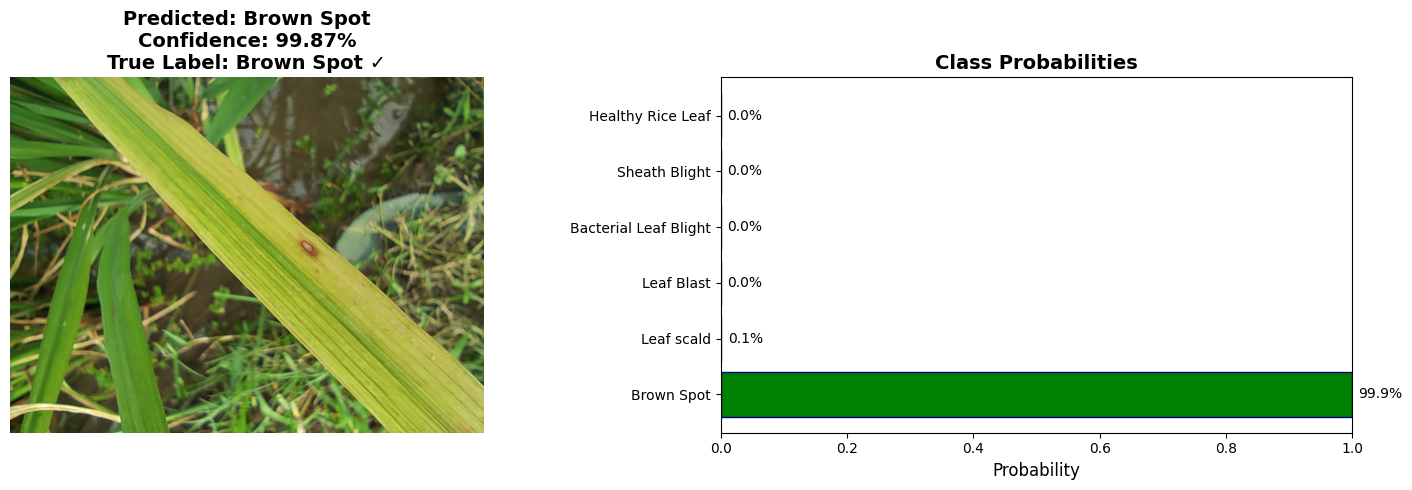

In [ ]:
# Test loading and using the saved model
print("="*60)
print("TESTING SAVED MODEL")
print("="*60)

# Load the model (simulating fresh start)
loaded_detector = RiceLeafDiseaseDetector.load(model_save_path, device='cpu')

# Test on a random image
test_sample = test_df.sample(1).iloc[0]
test_image_path = test_sample['path']
true_class = test_sample['class_name']

print(f"\nTest Image: {test_image_path}")
print(f"True Label: {true_class}\n")

# Simple prediction
result = loaded_detector.predict(test_image_path)
print("Simple Prediction:")
print(f"  Disease: {result['predicted_class']}")
print(f"  Confidence: {result['confidence']:.2%}")
print(f"  Correct: {'✓' if result['predicted_class'] == true_class else '✗'}")

# Prediction with probabilities
result_with_probs = loaded_detector.predict(test_image_path, return_probs=True)
print("\nPrediction with All Probabilities:")
print(f"  Disease: {result_with_probs['predicted_class']}")
print(f"  Confidence: {result_with_probs['confidence']:.2%}")
print("  All Probabilities:")
for cls, prob in sorted(result_with_probs['all_probabilities'].items(), 
                        key=lambda x: x[1], reverse=True):
    print(f"    {cls}: {prob:.2%}")

# Visualize
visualize_prediction(
    test_image_path, 
    result['predicted_class'], 
    result['confidence'],
    result_with_probs['all_probabilities'],
    true_class
)